In [1]:
import nltk
from nltk.metrics import jaccard_distance
from scipy.stats import pearsonr
from nltk.wsd import lesk
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from scipy import spatial
from nltk.metrics import jaccard_distance
import re

In [2]:
with open('./given/trial/STS.input.txt') as input:
    corpus = input.read()
corpus

'id1\tThe bird is bathing in the sink.\tBirdie is washing itself in the water basin.\nid2\tIn May 2010, the troops attempted to invade Kabul.\tThe US army invaded Kabul on May 7th last year, 2010.\nid3\tJohn said he is considered a witness but not a suspect.\t"He is not a suspect anymore." John said.\nid4\tThey flew out of the nest in groups.\tThey flew into the nest together.\nid5\tThe woman is playing the violin.\tThe young lady enjoys listening to the guitar.\nid6\tJohn went horse back riding at dawn with a whole group of friends.\tSunrise at dawn is a magnificent view to take in if you wake up early enough for it.\n'

## Initialize pos tagger
We initialize the pos tagger that we will later use to get the pos tag of each word in order to obtain the sense

In [3]:
from nltk.tag.perceptron import PerceptronTagger
from nltk.corpus import treebank
pos_model = PerceptronTagger(load=False)
pos_model.train(treebank.tagged_sents())
postag_mapper = {
    'VERB': 'v',
    'NOUN': 'n',
    'ADJ': 'a',
    'ADV': 'r'
}

The following functions will get the sense of each word in the sense passed sentence. 
Some alternatives to the default lesk algorithm are implemented aswell

In [4]:
#basic Lesk: compare to definition + non-alpha chars removed
def alpha_only_lesk_definition(context_sentence, ss_sentence):
    ss_definition = ss_sentence.definition()
    
    #remove non-alphanum characters
    ss_definition =  set(re.sub("[^ \w]"," ", ss_definition).strip().split())
    context_sentence = set(re.sub("[^ \w]"," ", context_sentence).strip().split())
    
    return len(context_sentence.intersection(ss_definition))

#Lesk using lemmas: compare to definition + non-alpha chars removed
def alpha_lemma_lesk_definition(context_sentence, ss_sentence):
    ss_definition = ss_sentence.definition()
    
    #remove non-alphanum characters
    ss_definition =  set(re.sub("[^ \w]"," ", ss_definition).strip().split())
    context_sentence = set(re.sub("[^ \w]"," ", context_sentence).strip().split())
    
    lemmatizer = WordNetLemmatizer()    
    ss_definition = set([lemmatizer.lemmatize(w) for w in ss_definition])
    context_sentence = set([lemmatizer.lemmatize(w) for w in ss_definition])
    
    return len(context_sentence.intersection(ss_definition))

#modified Lesk: compare to examples + non-alpha chars removed
def alpha_only_lesk_example(context_sentence, ss_sentence):
    ss_definition = ss_sentence.definition()
    
    #remove non-alphanum characters
    ss_definition =  set(re.sub("[^ \w]"," ", ss_definition).strip().split())
    context_sentence = set(re.sub("[^ \w]"," ", context_sentence).strip().split())
    
    return len(context_sentence.intersection(ss_definition))

#basic Lesk: compare to definition + non-alpha chars & stopwords removed
def alpha_no_stop_lesk(context_sentence, ss_sentence):
    sw = set(stopwords.words('english'))
    ss_definition = ss_sentence.definition()
    
    #remove non-alphanum characters
    ss_definition =  re.sub("[^ \w]"," ", ss_definition).strip().split()
    context_sentence = re.sub("[^ \w]"," ", context_sentence).strip().split()
    
    ss_definition =  set([w for w in ss_definition if w not in sw])
    context_sentence = set([w for w in context_sentence if w not in sw])
    
    return len(context_sentence.intersection(ss_definition))

#convert word list to numerical vector 1 = a is in set (a,b), 0 = not in set
def words2vector(list1, list2, wordset):
    num_vec = []
    for word in wordset:
        if word in list1:
            num_vec.append(1)
        else:
            num_vec.append(0)
     
    #print(num_vec)
    return num_vec

#cosine similarity non-alpha chars removed
def cosine_similarity(context_sentence, ss_sentence):
    ss_definition = ss_sentence.definition()
    
    #remove non-alphanum characters
    ss_definition =  re.sub("[^ \w]"," ", ss_definition).strip().split()
    context_sentence = re.sub("[^ \w]"," ", context_sentence).strip().split()
    
    wordset = set(ss_definition).union(set(context_sentence))
    cos_similarity = 1 - spatial.distance.cosine(words2vector(ss_definition, context_sentence, wordset), words2vector(context_sentence, ss_definition, wordset))

    return cos_similarity

#jaccard similarity non-alpha chars removed
def jaccard_sim(context_sentence, ss_sentence):
    ss_definition = ss_sentence.definition()
    
    #remove non-alphanum characters
    ss_definition =  set(re.sub("[^ \w]"," ", ss_definition).strip().split())
    context_sentence = set(re.sub("[^ \w]"," ", context_sentence).strip().split())

    return 1 - jaccard_distance(ss_definition, context_sentence)

In [5]:
def get_definition(word, pos_tag, context, strategy):
    synsets = wn.synsets(word, pos_tag)
    if len(synsets) == 0: return None
    _, sense = max((strategy(' '.join(context), ss), ss) for ss in synsets)
    return sense
    
def sentence_to_sense(sentence, strategy=alpha_only_lesk_definition):
    res = []
    for word, pos_tag in pos_model.tag(sentence):
        pos_tag = nltk.tag.mapping.map_tag('en-ptb', 'universal', pos_tag)
        if pos_tag in postag_mapper:
            sense = get_definition(word, postag_mapper[pos_tag], sentence, strategy)
            res.append(sense or word)
        else:
            res.append(word)
    return res

## Divide the text into pairs of sentences
We take the text and split it by their id, getting pairs of sentences separated by a tab, later we split those sentences by that tab.

In [6]:
original_sentences = [
        list(map(lambda sentence: nltk.word_tokenize(sentence), sentence_pair.strip().split('\t')))
        for sentence_pair in re.compile('id[\d]\t').split(corpus) 
        if sentence_pair != ''
]

## Calculate the Jaccard distance among the pairs of sentences
We calculate the distance between the pairs of sentences to give a measure of their similarity and we contrast it with the golden ratio which is a real measure of the similarity from 0 to 5 being 0 phrases that are completely different and 5 phrases that mean exactly the same

In [7]:
golden_ratios = [0, 1, 2, 3, 4, 5]
lesk_variants = [alpha_only_lesk_definition, alpha_lemma_lesk_definition, alpha_only_lesk_example, alpha_no_stop_lesk, cosine_similarity, jaccard_sim]
pearsons = []
for lesk_variant in lesk_variants:
    print(f'Lesk Variant: {lesk_variant.__name__}')
    sentences = [
        list(map(lambda s: sentence_to_sense(s, lesk_variant), sentence_pair))
        for sentence_pair
        in original_sentences
    ]
    jaccard_distances = [jaccard_distance(*map(lambda s: set(s), sentence_pairs)) for sentence_pairs in sentences]
    for golden_ratio, distance in zip(golden_ratios, jaccard_distances):
        print(f'Jaccard distance is {distance:.2f} and its real golden ratio is {golden_ratio}')
    pearson = pearsonr(jaccard_distances, golden_ratios)[0]
    pearsons.append(pearson)
    print(f'Pearson linear correlation coefficient is: {pearson}')

Lesk Variant: alpha_only_lesk_definition
Jaccard distance is 0.69 and its real golden ratio is 0
Jaccard distance is 0.74 and its real golden ratio is 1
Jaccard distance is 0.62 and its real golden ratio is 2
Jaccard distance is 0.67 and its real golden ratio is 3
Jaccard distance is 0.77 and its real golden ratio is 4
Jaccard distance is 0.90 and its real golden ratio is 5
Pearson linear correlation coefficient is: 0.649575809103873
Lesk Variant: alpha_lemma_lesk_definition
Jaccard distance is 0.69 and its real golden ratio is 0
Jaccard distance is 0.67 and its real golden ratio is 1
Jaccard distance is 0.62 and its real golden ratio is 2
Jaccard distance is 0.55 and its real golden ratio is 3
Jaccard distance is 0.77 and its real golden ratio is 4
Jaccard distance is 0.86 and its real golden ratio is 5
Pearson linear correlation coefficient is: 0.5191281385576342
Lesk Variant: alpha_only_lesk_example
Jaccard distance is 0.69 and its real golden ratio is 0
Jaccard distance is 0.74 and

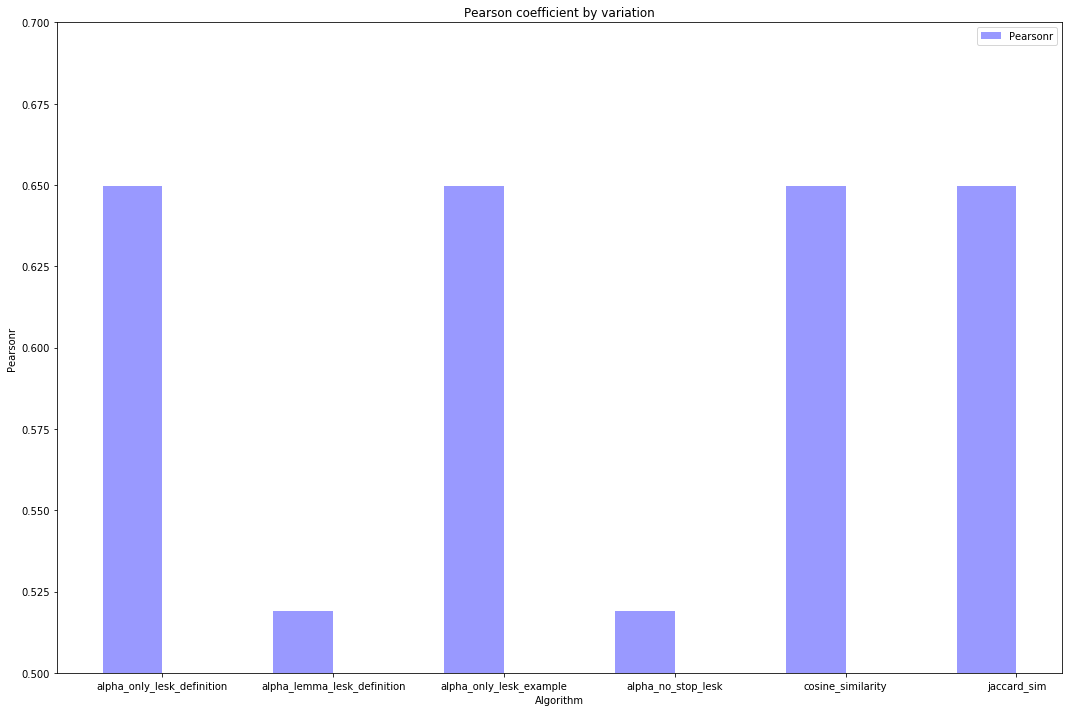

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
import numpy as np

n_groups = len(lesk_variants)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

ax.bar(index, pearsons, bar_width,
        alpha=0.4, color='b', label='Pearsonr')
plt.ylim(0.5, 0.7)
ax.set_xlabel('Algorithm')
ax.set_ylabel('Pearsonr')
ax.set_title('Pearson coefficient by variation')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([f.__name__ for f in lesk_variants])
ax.legend()

fig.tight_layout()
plt.show()